#                                             Big Mart Sale Prediction

## Stage 1: Loading required Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Import mode function:
from scipy.stats import mode
from sklearn.linear_model import *
import csv as csv
from scipy.stats import mode
from sklearn import cross_validation, metrics

## Stage 2: Loading the data files from the local disk

In [14]:
#Read files from the local disk and sored in the variables viz train and test :
train = pd.read_csv("F://Python//train.csv")
test = pd.read_csv("F://Python//test.csv")

In [15]:
train.columns = ['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']
test.columns = ['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type']

## Stage 3: Exploring the data

In [16]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print train.shape, test.shape, data.shape

(8523, 13) (5681, 12) (14204, 13)


Checking whether data contains NA/Null values

In [17]:
data.isnull().values.any()

True

In [18]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

Checking the statistics

In [19]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [20]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [21]:
#Filter categorical variables
cat_col = [x for x in data.dtypes.index if data.dtypes[x]=='object']

#Exclude ID cols and source as they are not needed for model building
cat_col = [x for x in cat_col if x not in ['Item_Identifier','Outlet_Identifier','source']]

#Print frequency of categories
for col in cat_col:
    print '\nFrequency of Categories for varible %s'%col
    print data[col].value_counts()


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

## Stage 4: Visualizing the Data for better understanding

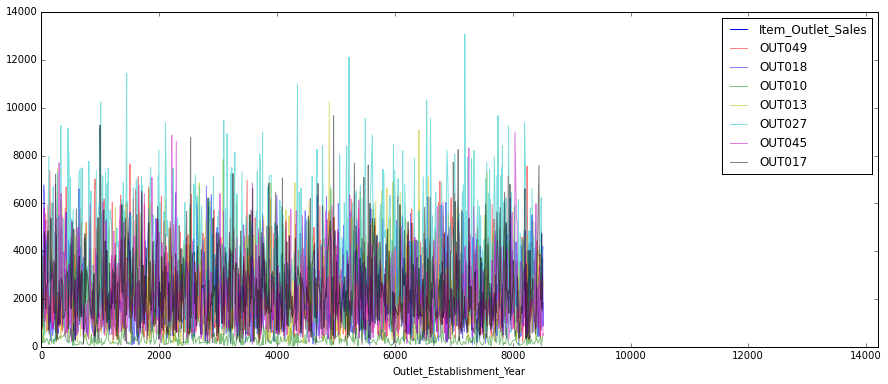

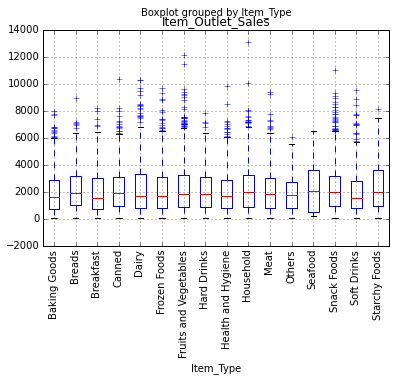

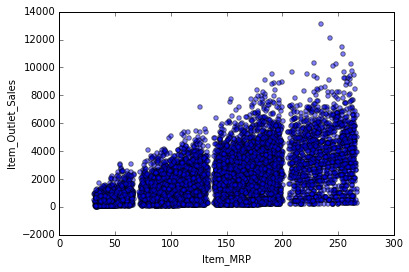

In [22]:
#How Establishment year of an outlet year has an impact on sales of that outlet
data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().plot();

#Sales across different outlets
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k']

for i, s in enumerate(data.Outlet_Identifier.unique()[:7]):
    data[data.Outlet_Identifier == s].Item_Outlet_Sales.plot(c=colors[i], figsize=(15, 6), label=s, alpha=.5)
    plt.legend(loc='best');

#Correlation between item type and sales for a particular store
data.boxplot(column='Item_Outlet_Sales', by='Item_Type')
plt.xticks(rotation=90);

#Analysis of item visibility with item outlet sales
plt.scatter(data.Item_Visibility, data.Item_Outlet_Sales, alpha=.5);

#Correlation between item prices and item outlet sales
data.plot(kind='scatter', x = 'Item_MRP', y = 'Item_Outlet_Sales', alpha=.5);

## Stage 5A: Imputing NA values for continuous variables by replacing them with Mean

In [23]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 
print 'Orignal #missing: %d'% sum(miss_bool)
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[x])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


## Stage 5B: Imputing NA values for Categorical variables by replacing them with Mode

In [24]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x)) )
print 'Mode for each Outlet_Type:'
print outlet_size_mode

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print '\nOrignal #missing: %d'% sum(miss_bool)
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print sum(data['Outlet_Size'].isnull())

Mode for each Outlet_Type:
Outlet_Type
Grocery Store          ([Small], [880.0])
Supermarket Type1     ([Small], [3100.0])
Supermarket Type2    ([Medium], [1546.0])
Supermarket Type3    ([Medium], [1559.0])
Name: Outlet_Size, dtype: object

Orignal #missing: 4016
0


C:\Users\Suhas\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


## Stage 6: Feature Engineering

In [25]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

In [26]:
#Products with higher visibility are likely to sell more.
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product as there is no sense if Item is not visible in the store 
#0 means no Visibility
miss_bool = (data['Item_Visibility'] == 0)

print 'Number of 0 values initially: %d'%sum(miss_bool)
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print 'Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0)

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [27]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


Creating a broad category of Type of Item

In [28]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

Determine the years of operation of a store so that it will be easier to do further calculation

In [29]:
#Years:
print data['Outlet_Establishment_Year'].describe()

#here we are subtrating each year from 2013 as it is given in the problem itself.
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean      1997.830681
std          8.371664
min       1985.000000
25%       1987.000000
50%       1999.000000
75%       2004.000000
max       2009.000000
Name: Outlet_Establishment_Year, dtype: float64


count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [30]:
#Change categories of low fat:
print 'Original Categories:'
print data['Item_Fat_Content'].value_counts()

#correcting the typos and differences in representation in categories of Item_Fat_Content variable
print '\nModified Categories:'
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
print data['Item_Fat_Content'].value_counts()

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [31]:
#Mark non-consumables as separate category in low_fat as "Non-Edible"
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [32]:
data.head(3)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Visibility_MeanRatio,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,0.931078,Food,14
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,0.933420,Drinks,4
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,0.960069,Food,14


Data Conversion into Numerical type since scikit-learn accepts only numerical variables, we converted all categories of nominal variables into numeric types.

In [33]:
##Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#New variable for outlet since we want Outlet_Identifier to be numerical without changing it's original type.
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [34]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [35]:
data.head(3).transpose()

,0,1,2
Item_Identifier,FDA15,DRC01,FDN15
Item_MRP,249.809,48.2692,141.618
Item_Outlet_Sales,3735.14,443.423,2097.27
Item_Type,Dairy,Soft Drinks,Meat
Item_Visibility,0.0160473,0.0192782,0.0167601
Item_Weight,9.3,5.92,17.5
Outlet_Establishment_Year,1999,2009,1999
Outlet_Identifier,OUT049,OUT018,OUT049
source,train,train,train
Item_Visibility_MeanRatio,0.931078,0.93342,0.960069


In [36]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Size_3                  uint8
Outlet_Size_4                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
I

In [37]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)
#We can notice that each row will have only one of the columns as 1 corresponding to the category in the original variable.

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [38]:
data.head(3)

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,source,Item_Visibility_MeanRatio,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,train,0.931078,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,train,0.933420,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,train,0.960069,...,0,0,0,0,0,0,0,0,0,1


We are exporting this modified data into Train and test files so that we can use it for multiple algorithms easily.

In [39]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("F://Python//train_modified.csv",index=False)
test.to_csv("F://Python//test_modified.csv",index=False)

C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Stage 7: Model Building

Baseline Model

In [40]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("F://Python//alg0.csv",index=False)

C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Creating function 

In [48]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

## Linear Regression Model


Model Report
RMSE : 1127
CV Score : Mean - 1129 | Std - 43.06 | Min - 1076 | Max - 1209


C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


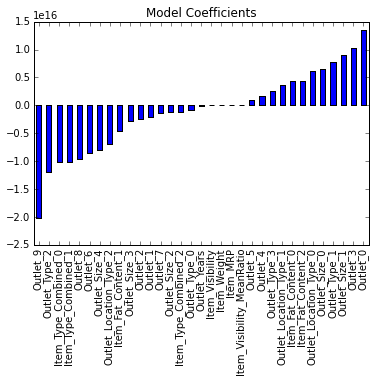

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
LR = LinearRegression(normalize=True)
modelfit(LR, train, test, predictors, target, IDcol, 'LR.csv')
coef1 = pd.Series(LR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

## Ridge Regression Model


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.57 | Min - 1076 | Max - 1217


C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


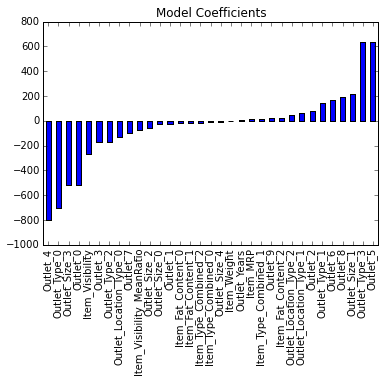

In [50]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
RR = Ridge(alpha=0.05,normalize=True)
modelfit(RR, train, test, predictors, target, IDcol, 'RR.csv')
coef2 = pd.Series(RR.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

## Decision Tree Model


Model Report
RMSE : 1058
CV Score : Mean - 1092 | Std - 45.77 | Min - 1004 | Max - 1188


C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


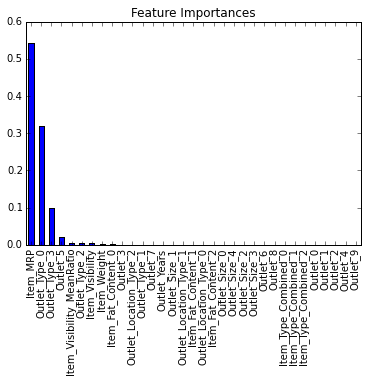

In [51]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(DT, train, test, predictors, target, IDcol, 'DT.csv')
coef3 = pd.Series(DT.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

## Random Forest Model


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.58 | Min - 1020 | Max - 1161


C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


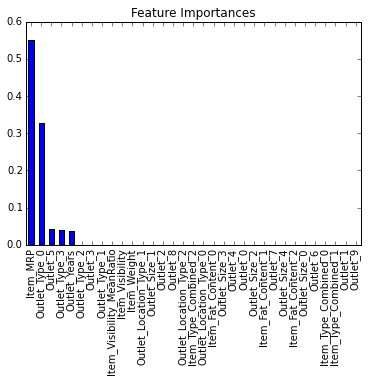

In [52]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
RF = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(RF, train, test, predictors, target, IDcol, 'RF.csv')
coef5 = pd.Series(RF.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.77 | Min - 1019 | Max - 1161


C:\Users\Suhas\Anaconda\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


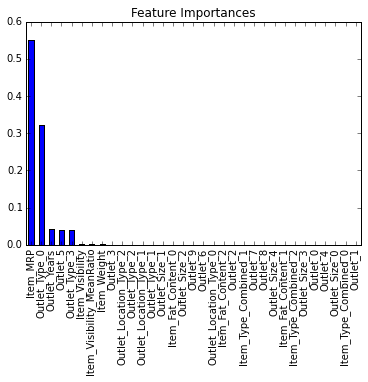

In [53]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
RF2 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(RF2, train, test, predictors, target, IDcol, 'RF2.csv')
coef6 = pd.Series(RF2.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

# END